Import and Function definition:

DeepLearning framework:
tensorflow 2.x
Keras 2.3
tensorflow_hub

Image processing framework:
PIL
cv2

Utilit:

google.colab




In [31]:
#Install

# Currently %tensorflow_version 2.x installs beta1, which doesn't work here.
# %tensorflow_version can likely be used after 2.0rc0  
#!pip install tf-nightly-gpu-2.0-preview
#!pip install tf-nightly-gpu-2.0-preview
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow

import tensorflow as tf

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub
# Keras modules.
from tensorflow.python.keras.layers import Dense,Input, Conv2D, Flatten, Dropout, MaxPooling2D,Conv1D,Subtract, BatchNormalization 
from tensorflow.python.keras.models import Model

from tensorflow.python.keras.layers import Lambda, Conv1D, Reshape
from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def abs_layer(x):
  return tf.abs(x)


# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


Mount Google Drive and Read directori path to Image for **detect**

Подключаю диск и записываю директорию для чтения файлов на трекинг

In [45]:
from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/My Drive/Moutain_Bike/mountain-bike/'  #change dir to your project folder  



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read filename List (for detect).

Чтение имен кадров для трекинга в базе 

In [46]:
import os, fnmatch
listOfFiles = os.listdir(root_path)
pattern = '*.jpg'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[0]


array('/content/drive/My Drive/Moutain_Bike/mountain-bike/datasets_36409_55264_TrackingDataset_Kwon_VTD_basketball_frame_0001.jpg',
      dtype='<U122')

Создание маленькой сети для классификации

In [7]:
from tensorflow.python.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train=x_train/255
x_test =x_test/255
y_train100=to_categorical(y_train,100)
y_test100=to_categorical(y_test,100)
y_train100.shape

169009152/169001437 [==============================] - 4s 0us/step


(50000, 100)

Epoch 1/20
400/400 [==============================] - 4s 9ms/step - loss: 3.8260 - accuracy: 0.1201 - val_loss: 3.4235 - val_accuracy: 0.1918
Epoch 2/20
400/400 [==============================] - 3s 8ms/step - loss: 3.1277 - accuracy: 0.2387 - val_loss: 3.0607 - val_accuracy: 0.2525
Epoch 3/20
400/400 [==============================] - 3s 8ms/step - loss: 2.7682 - accuracy: 0.3086 - val_loss: 2.9716 - val_accuracy: 0.2715
Epoch 4/20
400/400 [==============================] - 3s 8ms/step - loss: 2.4829 - accuracy: 0.3666 - val_loss: 2.7810 - val_accuracy: 0.3148
Epoch 5/20
400/400 [==============================] - 3s 8ms/step - loss: 2.2032 - accuracy: 0.4236 - val_loss: 2.8432 - val_accuracy: 0.3174
Epoch 6/20
400/400 [==============================] - 3s 8ms/step - loss: 1.9405 - accuracy: 0.4823 - val_loss: 2.8235 - val_accuracy: 0.3284
Epoch 7/20
400/400 [==============================] - 3s 8ms/step - loss: 1.6896 - accuracy: 0.5376 - val_loss: 3.0206 - val_accuracy: 0.3237


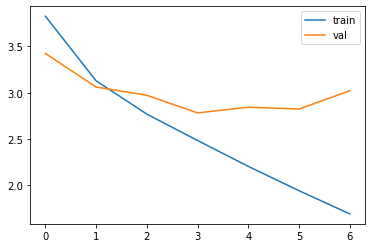

In [76]:
def model_classif(level=2):
  x_inp =Input(shape=(32,32,3))
  
  x=BatchNormalization()(x_inp)
  x=Conv2D(32, (5, 5) , activation='relu', padding='same')(x)
  x=Conv2D(32, (3, 3) , activation='relu', padding='same')(x)
  x=MaxPooling2D()(x)
  for k in range(level):
    x=Conv2D(32, (3, 3) , activation='relu', padding='same')(x)
    x=Conv2D(32, (3, 3) , activation='relu', padding='same')(x)
    x=MaxPooling2D()(x)
  x=Flatten()(x)
  x_1=Dense(600, activation = 'relu')(x)
  x_2=Dense(100,activation='softmax')(x_1)
  classifier =Model(x_inp,x_2)
  siam_classifier =Model(x_inp,x_1)
  classifier.compile(optimizer='Adam', loss=['categorical_crossentropy'],metrics=['accuracy'])
  return  classifier ,siam_classifier

classifier ,siam_classifier = model_classif(level=2)

el=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=3,verbose=0, mode='auto', baseline=None,restore_best_weights=False)
hist=classifier.fit(x_train,y_train100,batch_size=100,epochs=20,validation_split=0.2,callbacks=[el])
plt.plot(hist.history['loss'],label='train')
plt.plot(hist.history['val_loss'],label='val')
plt.legend()
plt.show()


In [133]:
classifier.save_weights('classif.hdf5')

# **Формируем нейронную сеть - сиамского типа**

Create SiamNet:



In [87]:
classifier1 ,siam_classifier1 = model_classif(level=2)

classifier.load_weights('classif.hdf5')
classifier1.load_weights('classif.hdf5')

classifier.trainable=False
classifier1.trainable=False


flat1 = (classifier1.layers[-2].output)
flat2 = (classifier.layers[-2].output)

flat_1=Subtract()([flat1,flat2])
flat_ = Lambda(abs_layer)(flat_1)
class1 = Dense(100, activation='relu')(flat_)
class1=BatchNormalization()(class1)
class1 = Dense(20, activation='relu')(class1)
class2=Flatten()(class1)
output = Dense(1, activation='sigmoid')(class2)

model_ = Model([classifier.input,classifier1.input], output)
model_.compile(optimizer='SGD',loss=['binary_crossentropy'],metrics=['accuracy'])

el=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5,verbose=0, mode='auto', baseline=None,restore_best_weights=False)
model_.summary()


Model: "functional_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 32, 32, 3)    12          input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 32, 32, 3)    12          input_19[0][0]                   
______________________________________________________________________________________

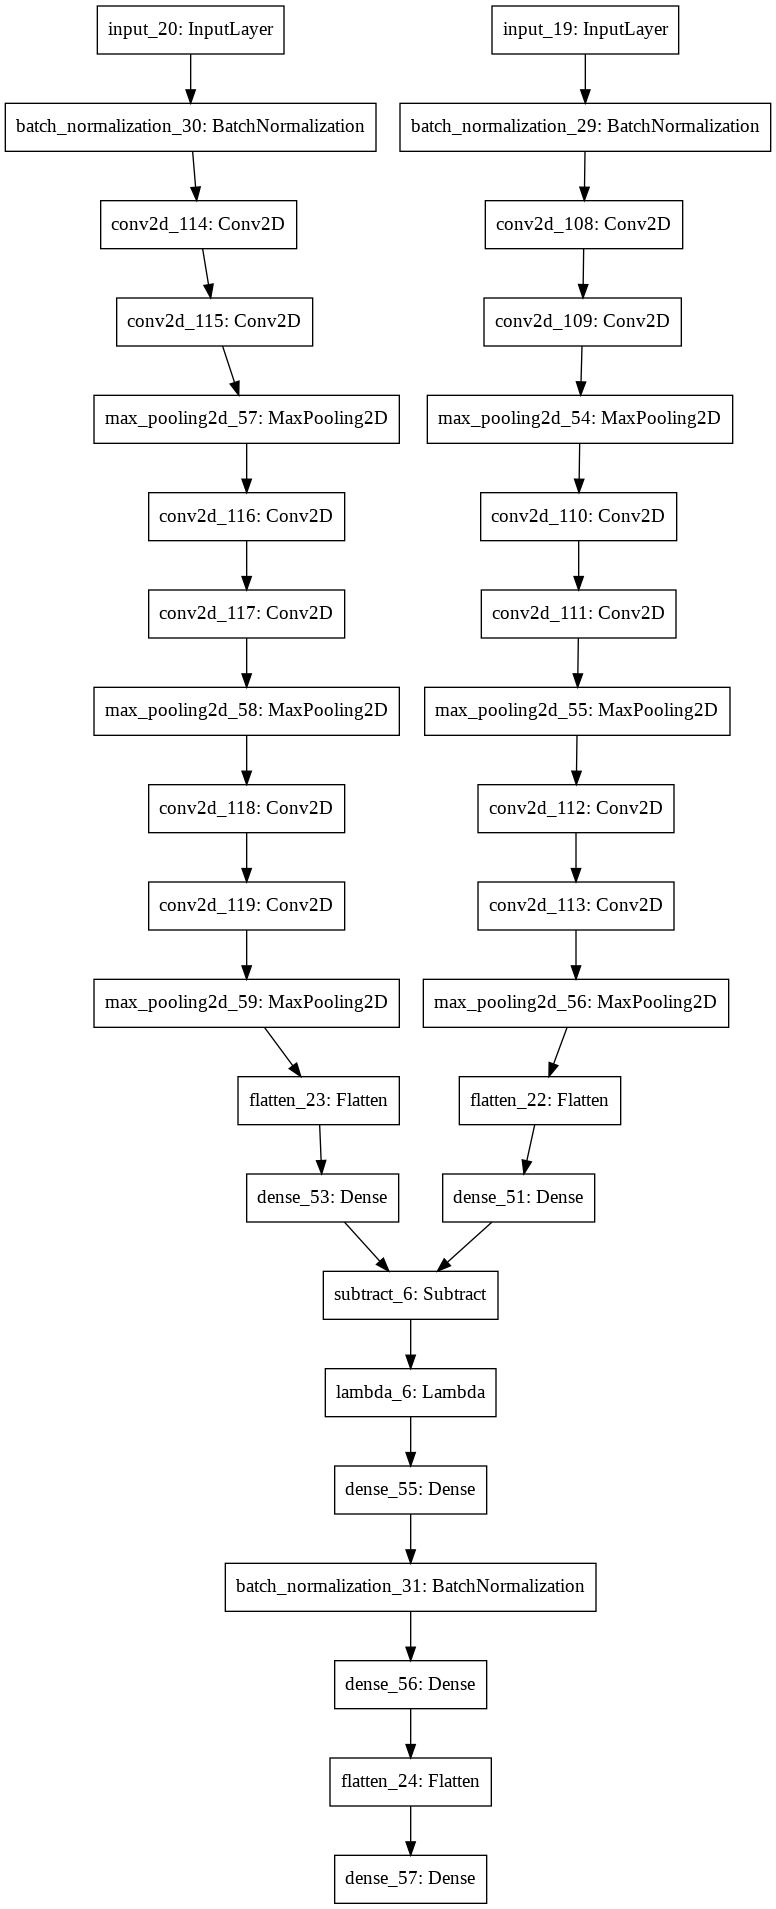

In [80]:
plot_model(model_, to_file='model_.png')

Data set5 for SiamNet Train:

1th Image - cifar100, 2th Image -augmentation(cifar100) -> Label = 1

1th Image - cifar100, 2th Image - cifar100 -> Label = 0


1th Image - X1

2th Image - X2

Label - L

In [81]:
from tensorflow.python.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train=x_train/255
x_test =x_test/255
y_train100=to_categorical(y_train,100)
y_test100=to_categorical(y_test,100)
y_train100.shape

(50000, 100)

In [32]:
IDG = ImageDataGenerator(rotation_range=30,zoom_range=0.2,height_shift_range=0.2,width_shift_range=0.2,horizontal_flip=True ,rescale=1, brightness_range=[0.7, 0.9])

IDG.fit(x_train)


In [88]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train=x_train/255
x_test =x_test/255
N=20000
X1=[]
X2=[]

L=[]
for i in range(N):
  wi=np.random.randint(0,x_train.shape[0])
  wj=np.random.randint(0,x_train.shape[0])
  X1.append(x_train[wi])
  if wi == wj:
    I1=IDG.apply_transform(x_train[wi,:,:,:],IDG.get_random_transform((32,32,3)))/255
    X2.append(x_train[wj])
    L.append(1)
    #X2.append(x_train[wj])
  else :
    X1.append(x_train[wi])
    X2.append(x_train[wj])  
    L.append(0)  

  I1=IDG.apply_transform(x_train[wi,:,:,:],IDG.get_random_transform((32,32,3)))/255
  X2.append(I1)
  L.append(1)
 

    
X1=np.array(X1)
X2=np.array(X2)
L=np.array(L).astype('int')

Epoch 1/30
160/160 [==============================] - 2s 11ms/step - loss: 0.5647 - accuracy: 0.7086 - val_loss: 0.6697 - val_accuracy: 0.6410
Epoch 2/30
160/160 [==============================] - 1s 8ms/step - loss: 0.4146 - accuracy: 0.8127 - val_loss: 0.4661 - val_accuracy: 0.7782
Epoch 3/30
160/160 [==============================] - 1s 8ms/step - loss: 0.3603 - accuracy: 0.8406 - val_loss: 0.3803 - val_accuracy: 0.8306
Epoch 4/30
160/160 [==============================] - 1s 8ms/step - loss: 0.3309 - accuracy: 0.8537 - val_loss: 0.3483 - val_accuracy: 0.8497
Epoch 5/30
160/160 [==============================] - 1s 8ms/step - loss: 0.3127 - accuracy: 0.8625 - val_loss: 0.3330 - val_accuracy: 0.8547
Epoch 6/30
160/160 [==============================] - 1s 8ms/step - loss: 0.2979 - accuracy: 0.8700 - val_loss: 0.3230 - val_accuracy: 0.8584
Epoch 7/30
160/160 [==============================] - 1s 8ms/step - loss: 0.2877 - accuracy: 0.8744 - val_loss: 0.3162 - val_accuracy: 0.8627
Epoch

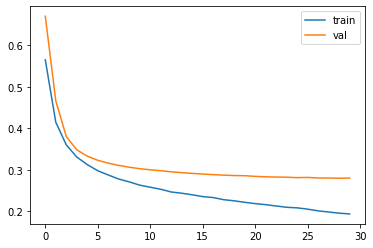

In [89]:
hist1=model_.fit([X1,X2],L,batch_size=200,epochs=30,validation_split=0.2, callbacks=[el])
plt.plot(hist1.history['loss'],label='train')
plt.plot(hist1.history['val_loss'],label='val')
plt.legend()
plt.show()

In [132]:
model_.save_weights('siam_net_weight.hdf5')

## **Import detection result**

## **Импорт и обработка результатов детектирования**

In [61]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  #read image
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  #print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """отрисовка одной рамки. из примера tensorflow"""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)


  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # 
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # 
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=30, min_score=0.01):
  """отрисовка рамок. из примера tensorflow"""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Загрузка детектора

In [160]:
#module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]
module_handle ="https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Формируем тензор

In [149]:
def load_img(path):
  # Делаем изображение на вход сети
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

Выполняем детектор

In [161]:

def run_detector(detector, path, numb=100):
  """ из примера tensorflow"""
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  print("**********converted_img")
  result = detector(converted_img)
  
  end_time = time.time()
  result = {key:value.numpy() for key,value in result.items()} 


  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=numb)

  display_image(image_with_boxes)
  return result

Возвращаем рамки для объектов

In [156]:
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
  """получить рамку из результатов детектора. из примера tensorflow"""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  #print(I_shape)
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      #print(imf.shape,imf[0,0,:])
      
      im_array.append(imf.copy())  
  return im_array

In [157]:
def get_boxes(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
  """строим картинку с рамками. из примера tensorflow"""
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

Проверяем детектор

In [158]:
#/content/drive/My Drive/Moutain_Bike/mountain-bike
List_name[0]

array('/content/drive/My Drive/Moutain_Bike/mountain-bike/datasets_36409_55264_TrackingDataset_Kwon_VTD_basketball_frame_0001.jpg',
      dtype='<U122')

**********converted_img


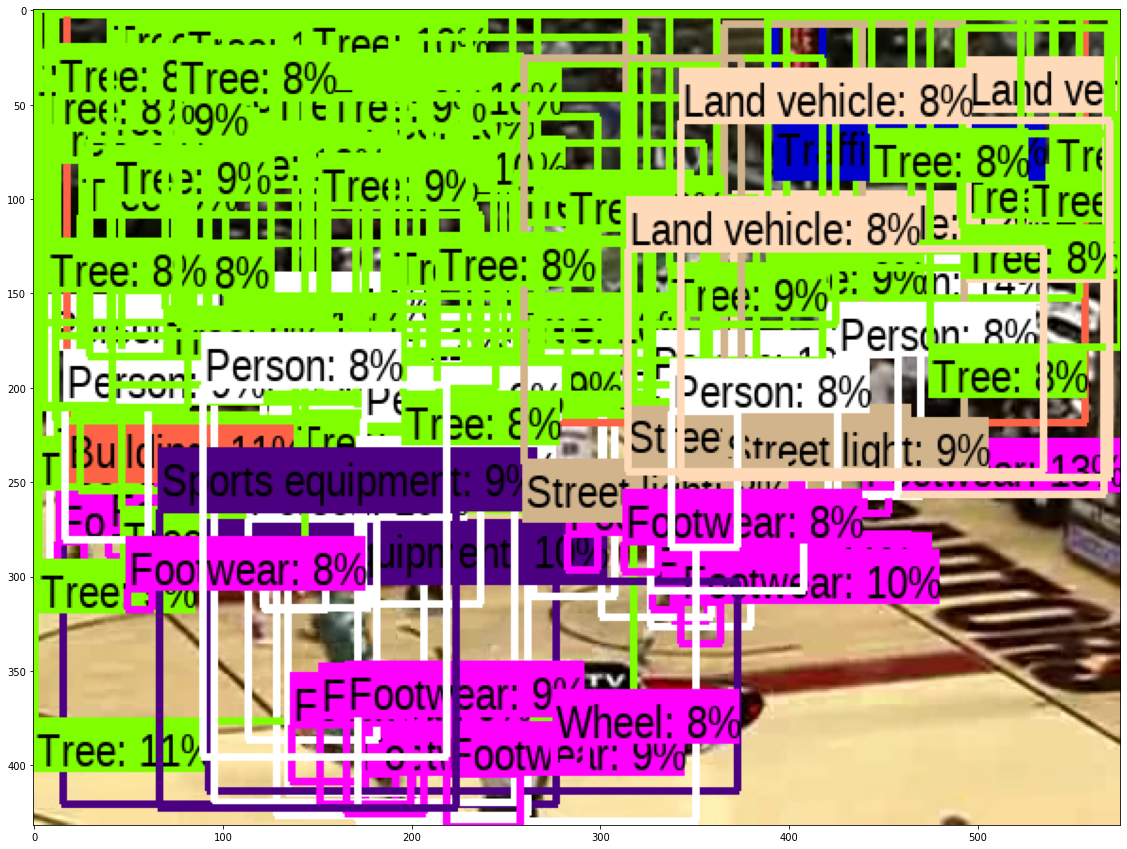

In [162]:
result = run_detector(detector, List_name[0])

In [ ]:
detector.signatures()

In [110]:
import cv2 as cv


# **Запуск трекинга**

1) читаем нулевой кадр и заполняем List_coord список координат объектов, где для каждого пишем : [[ymin, xmin, ymax, xmax], номер кадра = 0]
2) одновременно пишем список изображений от детектора imlist2 - и нормализуем его по уровняям [0,1] и размеру (32х32х3)

3) для следующих кадров повторяем:
  
  3.1) List_coord_old =List_coord
       imlist1=imlist2
  
  3.2) заполняем List_coord список координат объектов, где для каждого пишем : [[ymin, xmin, ymax, xmax], номер кадра = m]
  
  3.3) одновременно пишем список изображений от детектора imlist2 - и нормализуем его по уровняям [0,1] и размеру (32х32х3)
  
  3.4) делаем I_1,I_2 сетку примеров - все со всеми
  
  3.5) подаем примеры в сиамскую сеть predict()
  
  3.6) отсеиваемм примеры с порогом распознавания менее porog
  
  3.7) добавляем хорошие треки к списку найденых под кадров      

In [111]:

import warnings
warnings.simplefilter('ignore')

In [131]:

N=10
porog=0.95

List_coord=[]
result2 = run_detector(detector, List_name[0])
img2 = load_img(List_name[0])
imlist2=get_boxes(img2 , result2["detection_boxes"],
      result2["detection_class_entities"], result2["detection_scores"])

I1=[]
I2=[]
k=0
for i in imlist2:
  #print(result2["detection_class_entities"][k])
  if result2["detection_class_entities"][k]==b'Person':
    imgi=cv.resize(i,(32,32))/225
    I2.append(imgi)
    List_coord.append([result2["detection_boxes"][k].tolist(), 0])
  k += 1

  
#print(len(List_coord))  
#List_coord=np.array(List_coord)

for m in range(1,len(List_name)):
  plt.figure(figsize=(10,30))
  result1 = result2.copy()
  img1 = img2
  imlist1=imlist2.copy()

  result2 = run_detector(detector, List_name[m], numb=100)
  img2 = load_img(List_name[m])
  imlist2=get_boxes(img2 , result2["detection_boxes"], result2["detection_class_entities"], result2["detection_scores"])
  
  
  
  List_coord_old=List_coord.copy()
  List_coord=[]

  #List_coord=np.array(List_coord)
  #print('1:',len(List_coord))
  #print('0:',len(List_coord_old))
  I1=I2.copy()
  I2 =[]
  k = 0
  for i in imlist2:
    #print(result2["detection_class_entities"][k])
    if result2["detection_class_entities"][k] == b'Person':
      imgi=cv.resize(i,(32,32))/np.max(i)

      I2.append(imgi)
      List_coord.append([result2["detection_boxes"][k].tolist(), m])
    k += 1


  I_1=[]
  I_2=[]
  for i in I1:
    for j in I2:
      I_1.append(i)
      I_2.append(j)
  I_1=np.array(I_1)
  I_2=np.array(I_2)    
  p=model_.predict([I_1,I_2])  
  
  p_res=p.reshape((len(I1),len(I2)))
  ind_p= np.argmax(p_res,axis=1)

  k=0
  for i in range(len(List_coord_old)):
    #plt.subplot( )
    #print(p_res.shape,': ',i,ind_p[i])
    if p_res[i,ind_p[i]]>porog:
      #print(': ',i,ind_p[i])
      #print('--: ',len(List_coord))
      List_coord[ind_p[i]]=(List_coord_old[i]+List_coord[ind_p[i]])
      #print(List_coord_old[i]+[result2["detection_boxes"][ind_p[i]]])
      if k<N:
        plt.subplot(N,2,k*2+1)
        plt.imshow(I1[i][:,:,:])
        plt.title(str(i)+' = '+str(ind_p[i]))
        plt.subplot(N,2,(k+1)*2)
        plt.imshow(I2[ind_p[i]][:,:,:])

        plt.title('siam predict ='+str(p_res[i,ind_p[i]]))
        k +=1

  plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [122]:
(I1[i][0,0,0])

0.03137254901960784

выведем длину трекинга по последней List_coord

In [126]:
for i in range(len(List_coord)):
  print(len(List_coord[i])//2)

7
1
1
1
14
7
1
3
2
3
2
1
1
1
1


Выведем на экран трекинг объекта mm

[0.46451789140701294, 0.45876985788345337, 0.7189183831214905, 0.5358981490135193] 0
[0.46451789140701294, 0.45876985788345337, 0.7189183831214905, 0.5358981490135193] [''] [100]


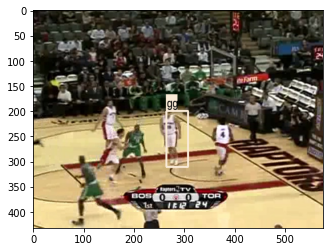

[0.4673176407814026, 0.4542485177516937, 0.7223990559577942, 0.5341792702674866] 1
[0.4673176407814026, 0.4542485177516937, 0.7223990559577942, 0.5341792702674866] [''] [100]


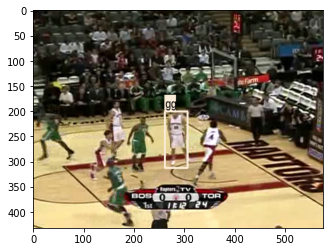

[0.46783486008644104, 0.4490768313407898, 0.7153767347335815, 0.5327887535095215] 2
[0.46783486008644104, 0.4490768313407898, 0.7153767347335815, 0.5327887535095215] [''] [100]


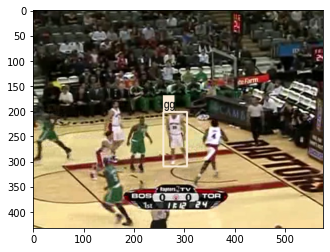

[0.46375730633735657, 0.4479396641254425, 0.7177165746688843, 0.5336511731147766] 3
[0.46375730633735657, 0.4479396641254425, 0.7177165746688843, 0.5336511731147766] [''] [100]


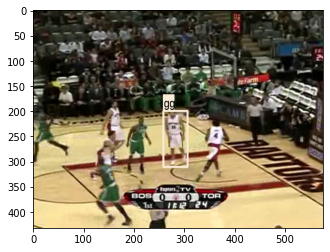

[0.4707304835319519, 0.4445679187774658, 0.7205846905708313, 0.528165340423584] 4
[0.4707304835319519, 0.4445679187774658, 0.7205846905708313, 0.528165340423584] [''] [100]


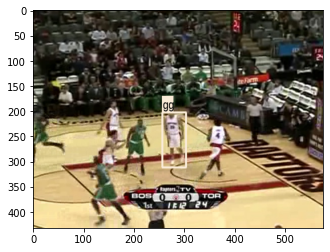

[0.47045063972473145, 0.43953460454940796, 0.724774956703186, 0.5117424726486206] 5
[0.47045063972473145, 0.43953460454940796, 0.724774956703186, 0.5117424726486206] [''] [100]


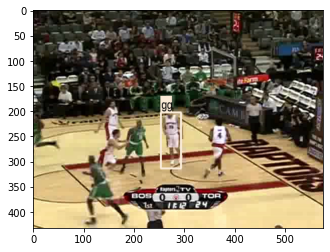

[0.46377068758010864, 0.43585044145584106, 0.7563580870628357, 0.5116883516311646] 6
[0.46377068758010864, 0.43585044145584106, 0.7563580870628357, 0.5116883516311646] [''] [100]


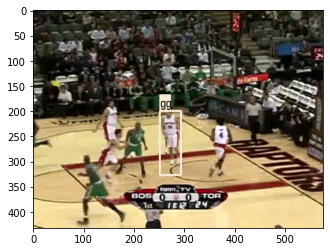

In [130]:
colors = list(ImageColor.colormap.values())

try:
  font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

mm = 5
for i in range(len(List_coord[mm]) // 2):
  print(List_coord[mm][i*2],List_coord[mm][i*2+1])
  img1 = load_img(List_name[m])
  img = img1.numpy()  
  h,w,c=img.shape
  ymin, xmin, ymax, xmax= (List_coord[mm][i*2])
  m= (List_coord[mm][i*2+1])

  print([ymin, xmin, ymax, xmax ], [''], [100])
  image_pil = Image.fromarray(np.uint8(img)).convert("RGB")
  draw_bounding_box_on_image(image_pil,ymin, xmin, ymax,xmax, colors[1],font, display_str_list=['gg'])
  np.copyto(img, np.array(image_pil))
  
  plt.imshow(img)
  plt.show()